In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [ ]:
path = r'/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark'
all_files = glob.glob(path + "/*.csv")

In [ ]:
dataset_conc = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df.replace(0, np.nan)
    df = df.dropna(axis=0, how='any', subset=['value'])
    df.value = preprocessing.normalize([df.value]).T
    dataset_conc.append(convert_2d(df))

frame = pd.concat(dataset_conc, axis=0, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-4-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-4-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-4-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-4-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index

In [ ]:
print(frame.columns)

RangeIndex(start=0, stop=61, step=1)


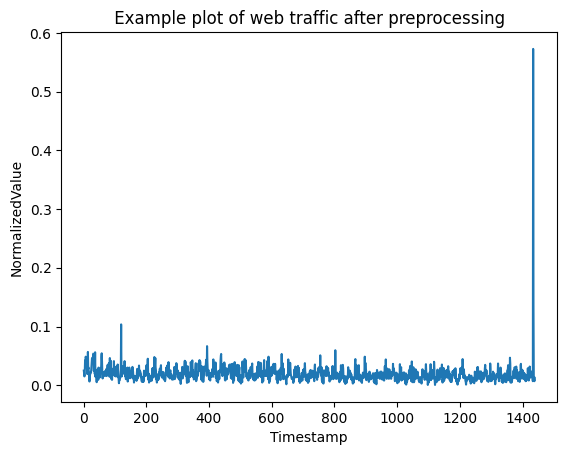

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(60, 1)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

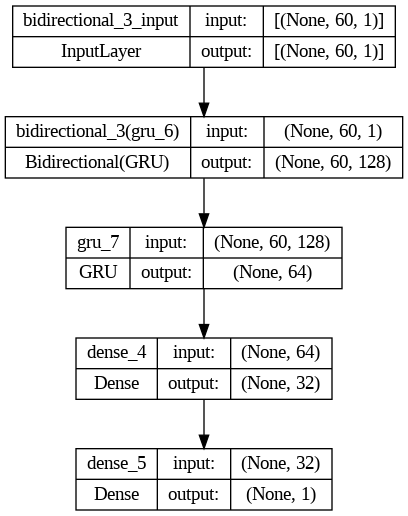

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import EarlyStopping

In [ ]:
y = frame.iloc[:, 60]
X = frame.iloc[:, 0:60]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
history = model.fit(x=X_train_resampled, y=y_train_resampled, batch_size=256, epochs=20, verbose=2,
                    sample_weight=class_weights_resampled,
                    validation_data=(X_test, to_categorical(y_test)))

Epoch 1/40


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

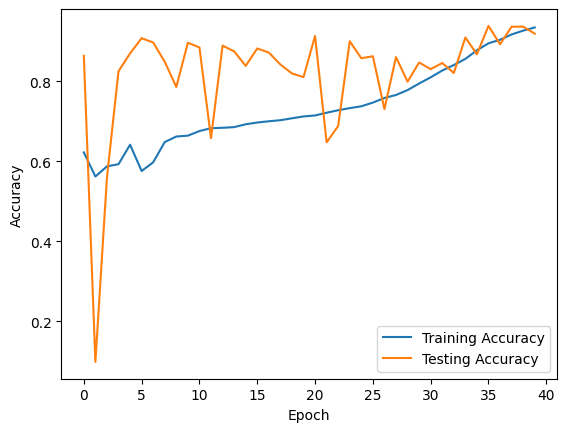

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

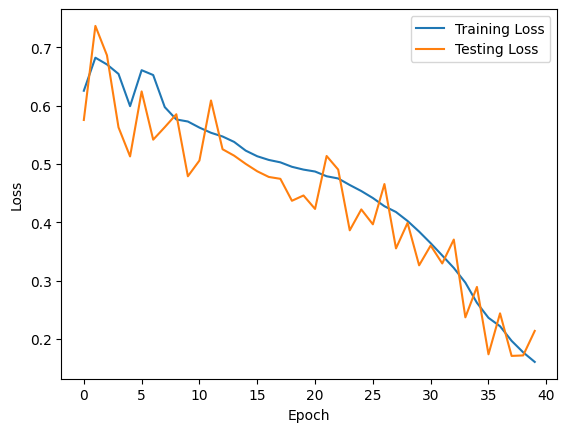

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


832/832 [==============================] - 6s 6ms/step


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'fpr' is not defined

<Figure size 800x600 with 0 Axes>

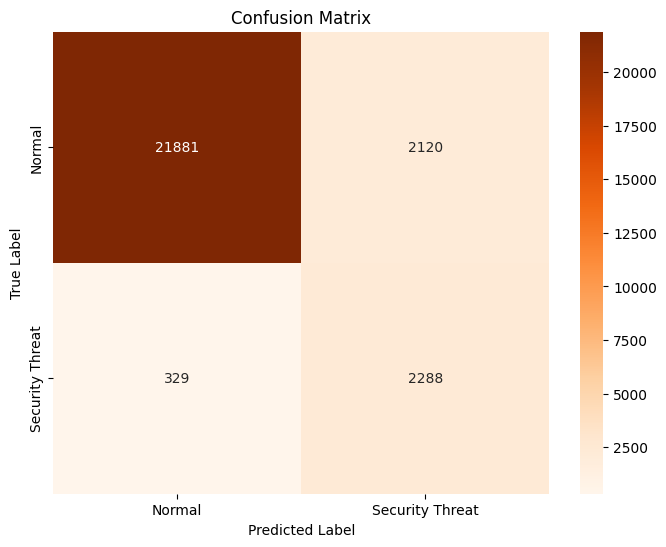

In [ ]:
Confusion_Matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=['Normal', 'Security Threat'], yticklabels=['Normal', 'Security Threat'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
Confusion_Matrix = confusion_matrix(y_test, y_pred)
Accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
F1_Score = f1_score(y_test, y_pred, average='binary')
sensitivity = recall
specificity = Confusion_Matrix[0, 0] / (Confusion_Matrix[0, 0] + Confusion_Matrix[0, 1])
false_positive_results = Confusion_Matrix[0, 1]
false_negative_results = Confusion_Matrix[1, 0]
kappa_coefficient = cohen_kappa_score(y_test, y_pred)

print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("Recall ", recall)
print("F1 Score ", F1_Score)
print("Specificity ", specificity)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets